In [1]:
%%bash
pip install timm -q

In [2]:
import os
import re
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.model_selection import KFold

In [3]:
SEED: int = 42
SIZE: int = 384


def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")

    
def get_image(path: str, size: int=224) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
    return cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_AREA)


def show_loss_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()

    
def show_accuracy_graphs(A: list) -> None:
    TA, VA = [], []
    for i in range(len(A)):
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TA) + 1)
    plt.figure()
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()
    

def show_lr_graph(LR: list) -> None:
    x_Axis = [i+1 for i in range(len(LR))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LR, "rx")
    plt.grid()
    plt.show()

In [4]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 size: int = 224,
                 num_samples: int=10000,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 ):
        self.seed = seed
        self.size = size
        self.num_samples = num_samples
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.33171, 0.40140, 0.42093], [0.23583, 0.24294, 0.24042]),
            transforms.RandomAffine(degrees=(-45, 45), translate=(0.15, 0.15), scale=(0.5, 1.5)),
            transforms.RandomHorizontalFlip(p=0.25),
            transforms.RandomVerticalFlip(p=0.25),
        ])
        self.valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.33171, 0.40140, 0.42093], [0.23583, 0.24294, 0.24042]),
        ])                        
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(
    seed=SEED, 
    size=SIZE
)

In [5]:
class DS(Dataset):
    def __init__(
        self, 
        image: np.ndarray,
        num_of_samples: int=5000,
        transform=None,
        device=None,
    ):
        
        self.image = image
        self.num_of_samples = num_of_samples
        self.transform = transform
        self.device = device
    
    def __len__(self):
        return self.num_of_samples
    
    def __getitem__(self, idx):
        return self.transform(self.image).to(self.device)

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
            
        self.encoder = timm.create_model("efficientnet_b4", pretrained=True)
        self.encoder = nn.Sequential(*[*self.encoder.children()][:-1])
        
        self.decoder = nn.Sequential()
        self.decoder.add_module("DC1", nn.ConvTranspose2d(in_channels=1792, out_channels=512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN1", nn.ReLU())
        self.decoder.add_module("UP1", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC2", nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN2", nn.ReLU())
        self.decoder.add_module("UP2", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC3", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN3", nn.ReLU())
        self.decoder.add_module("UP3", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC4", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN4", nn.ReLU())
        self.decoder.add_module("UP4", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC5", nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN5", nn.ReLU())
        self.decoder.add_module("UP5", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC6", nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN6", nn.ReLU())
        self.decoder.add_module("UP6", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC7", nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN7", nn.ReLU())
        self.decoder.add_module("UP7", nn.Upsample(scale_factor=2))
            
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False

    def forward(self, x):
        encoded = self.encoder(x)
        temp = encoded.unsqueeze(dim=2).unsqueeze(dim=3)
        decoded = self.decoder(temp)

        return encoded, decoded

In [7]:
def fit(model=None,
        optimizer=None, 
        scheduler_rlrop=None,
        scheduler_oclr=None,
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        save_path=None,
        device=None,
        verbose=False
) -> tuple:
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss: dict = {"train" : np.inf, "valid" : np.inf} 
        
    Losses: list = []
    LRs: list = []
        
    if fold: 
        name = f"state_fold_{fold}.pt"
    else: 
        name = f"state.pt"
    
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss: dict = {"train" : 0.0, "valid" : 0.0} 

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass: list = []
                
            for X in dataloaders[phase]:
                # X = X.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    _, d = model(X)
                    loss = torch.nn.MSELoss()(d, X)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        if scheduler_oclr: LRs.append(scheduler_oclr.get_last_lr())
        Losses.append(epochLoss)
    
        if scheduler_oclr:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_oclr.state_dict()}
        
        elif scheduler_rlrop:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_rlrop.state_dict()}
        
        else:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict()}
        
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict,os.path.join(save_path, name))
    
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, LRs, bestLoss, BLE, name

In [8]:
image: np.ndarray = get_image("../input/fdsimages/Image_2_1.jpg", size=cfg.size)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_ra2_320-7eb33cd5.pth



**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.85006 | Valid Loss: 0.96645 | Time: 248.92 seconds
Epoch: 2 | Train Loss: 0.83238 | Valid Loss: 0.86228 | Time: 244.06 seconds
Epoch: 3 | Train Loss: 0.73789 | Valid Loss: 0.84876 | Time: 244.14 seconds
Epoch: 4 | Train Loss: 0.65871 | Valid Loss: 0.68124 | Time: 242.44 seconds
Epoch: 5 | Train Loss: 0.55909 | Valid Loss: 0.65451 | Time: 243.94 seconds
Epoch: 6 | Train Loss: 0.54486 | Valid Loss: 0.46422 | Time: 242.86 seconds
Epoch: 7 | Train Loss: 0.35399 | Valid Loss: 0.44103 | Time: 243.32 seconds
Epoch: 8 | Train Loss: 0.33240 | Valid Loss: 0.42648 | Time: 242.71 seconds
Epoch: 9 | Train Loss: 0.32608 | Valid Loss: 0.43067 | Time: 240.81 seconds
Epoch: 10 | Train Loss: 0.31364 | Valid Loss: 0.44014 | Time: 240.56 seconds
Epoch: 11 | Train Loss: 0.31185 | Valid Loss: 0.41956 | Time: 241.20 seconds
Epoch: 12 | Train Loss: 0.30668 | Valid Los

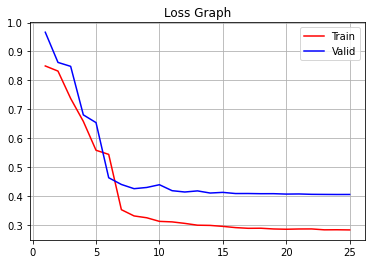


**************************************************



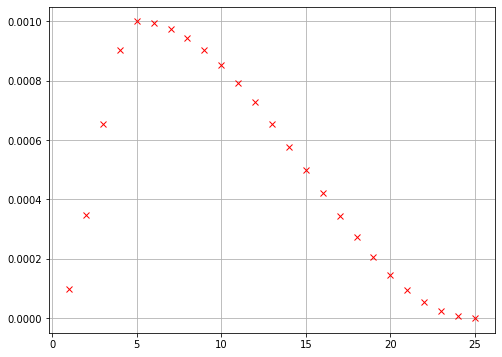


**************************************************



In [9]:
cfg.batch_size = 16
    
tr_data_setup = DS(
    image=image, 
    transform=cfg.train_transform,
    device=cfg.device
)

va_data_setup = DS(
    image=image, 
    transform=cfg.valid_transform,
    device=cfg.device
)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
    "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
}

cfg.steps_per_epoch=len(dataloaders["train"])

torch.manual_seed(cfg.seed)
model = Model().to(cfg.device)

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
# optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
# optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd, momentum=0.9)

scheduler_oclr = optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer, 
    max_lr=cfg.max_lr, 
    epochs=cfg.epochs, 
    steps_per_epoch=cfg.steps_per_epoch,
    pct_start=cfg.pct_start, 
    div_factor=cfg.div_factor, 
    final_div_factor=cfg.final_div_factor
)

# scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer=optimizer,
#     patience=cfg.patience,
#     eps=cfg.eps,
#     verbose=True
# )

# scheduler_oclr = None
scheduler_rlrop = None

L, LR, BL, _, _ = fit(
    model=model, 
    optimizer=optimizer, 
    scheduler_oclr=scheduler_oclr,
    scheduler_rlrop=scheduler_rlrop,
    epochs=cfg.epochs, 
    early_stopping_patience=cfg.early_stopping, 
    dataloaders=dataloaders, 
    device=cfg.device,
    save_path=cfg.save_path,
    fold=None,
    verbose=True
)

breaker()
show_loss_graphs(L)
breaker()
if scheduler_oclr:
    show_lr_graph(LR)
    breaker()